# Download datasets into 'Downloads Folder'

In [ ]:
!wget -P '~/Downloads/' https://static.mlalpha.com/public-datasets/ml-public-to-predict-v3.parquet
!wget -P '~/Downloads/' https://static.mlalpha.com/public-datasets/ml-public-train-v3.parquet
!wget -P '~/Downloads/' https://static.mlalpha.com/public-datasets/ml-public-test-app-v3.parquet

In [11]:
from lightgbm import LGBMRegressor
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os

## Choose the features and the target for training

In [17]:
FEATURES = [
    'sector_label',
    'fundamental_100',
    'fundamental_97',
    'fundamental_190',
    'fundamental_192',
    'fundamental_196',
    'fundamental_123',
    'fundamental_124',
    'fundamental_136',
    'fundamental_146',
    'fundamental_154',
    'fundamental_162',
    'technical_174',
    'technical_161',
    'technical_11',
    'technical_180',
    'technical_181',
    'technical_235',
    'technical_249'
]

TARGET = 'target_2W'


## Load datasets

### Load datasets into python dataframe

In [24]:
df_train = pd.read_parquet('~/Downloads/ml-public-train-v3.parquet', engine='pyarrow', columns=FEATURES + ['era', 'security_by_time', TARGET])
df_test = pd.read_parquet('~/Downloads/ml-public-test-app-v3.parquet', engine='pyarrow', columns=['security_by_time'] + FEATURES)
df_to_predict = pd.read_parquet('~/Downloads/ml-public-to-predict-v3.parquet', engine='pyarrow', columns=['security_by_time'] + FEATURES)

## Train the model based on the training dataset

**Explore the data**

In [25]:
df_train.describe()

,sector_label,fundamental_100,fundamental_97,fundamental_190,fundamental_192,fundamental_196,fundamental_123,fundamental_124,fundamental_136,fundamental_146,...,fundamental_162,technical_174,technical_161,technical_11,technical_180,technical_181,technical_235,technical_249,era,target_2W
count,1.819171e+06,1.831873e+06,1.707482e+06,1.673960e+06,1.804126e+06,1.703099e+06,1.549561e+06,1.590067e+06,1.712229e+06,1.803672e+06,...,1.672813e+06,1.746183e+06,1.682489e+06,1.672686e+06,1.749846e+06,1.501501e+06,1.748809e+06,1.753052e+06,1.831873e+06,1.712282e+06
mean,4.966340e-01,5.026627e-01,5.035512e-01,5.033554e-01,5.009749e-01,5.049247e-01,4.984370e-01,4.998617e-01,4.994382e-01,5.043801e-01,...,5.026741e-01,4.970734e-01,4.994817e-01,4.956104e-01,4.971442e-01,5.004666e-01,5.002671e-01,4.985943e-01,1.663047e+06,5.038264e-01
std,2.892140e-01,2.891567e-01,2.881331e-01,2.874947e-01,2.869611e-01,2.877583e-01,2.880038e-01,2.888955e-01,2.889005e-01,2.879871e-01,...,2.863527e-01,2.907377e-01,2.905442e-01,2.889670e-01,2.876751e-01,2.893753e-01,2.909629e-01,2.863536e-01,5.284327e+05,2.870178e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.022750e+05,0.000000e+00
25%,2.257257e-01,2.502063e-01,2.697698e-01,2.573435e-01,2.541291e-01,2.545541e-01,2.530989e-01,2.516697e-01,2.534215e-01,2.541805e-01,...,2.562841e-01,2.409644e-01,2.445281e-01,2.427436e-01,2.485850e-01,2.499067e-01,2.435998e-01,2.530477e-01,1.301195e+06,2.593654e-01
50%,4.069069e-01,5.049822e-01,5.068011e-01,5.035043e-01,4.993263e-01,5.080311e-01,4.965125e-01,5.002228e-01,4.993866e-01,5.075304e-01,...,5.054361e-01,4.988827e-01,5.020739e-01,4.952506e-01,4.986883e-01,5.010386e-01,5.010574e-01,4.980043e-01,1.770145e+06,5.063169e-01
75%,7.137137e-01,7.493201e-01,7.517889e-01,7.520172e-01,7.480648e-01,7.526061e-01,7.482331e-01,7.505509e-01,7.479759e-01,7.535075e-01,...,7.502569e-01,7.510936e-01,7.501101e-01,7.447792e-01,7.406673e-01,7.539262e-01,7.533262e-01,7.479116e-01,2.111405e+06,7.551838e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.345315e+06,1.000000e+00


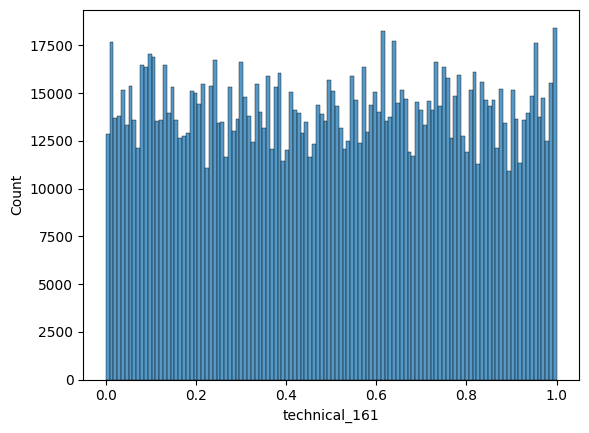

In [26]:
sns.histplot(df_train['technical_161']);

In [27]:
df_train.isna().count()

sector_label        1831873
fundamental_100     1831873
fundamental_97      1831873
fundamental_190     1831873
fundamental_192     1831873
fundamental_196     1831873
fundamental_123     1831873
fundamental_124     1831873
fundamental_136     1831873
fundamental_146     1831873
fundamental_154     1831873
fundamental_162     1831873
technical_174       1831873
technical_161       1831873
technical_11        1831873
technical_180       1831873
technical_181       1831873
technical_235       1831873
technical_249       1831873
era                 1831873
security_by_time    1831873
target_2W           1831873
dtype: int64

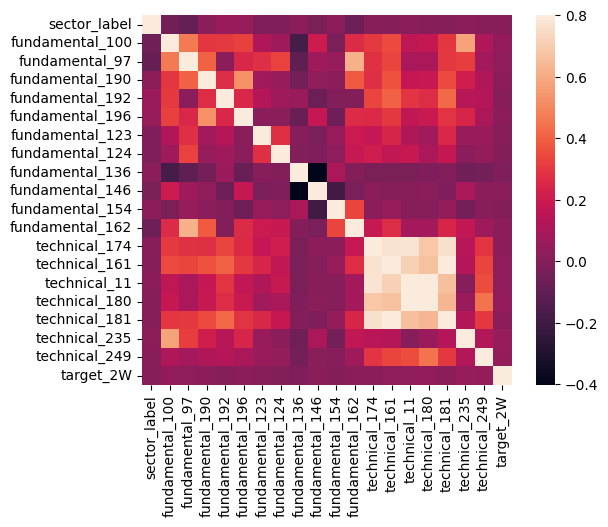

In [28]:
corrmat = df_train[FEATURES + [TARGET]].corr()
sns.heatmap(corrmat, vmax=.8, square=True);

**Before training and testing we need to do something with the NaN values**

In [29]:
# Simple NaN Fix, feel free to bring your own creativity!
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

**Test to train and predict on the train dataset**

This step is crutial if you want to improve your model

In [30]:
#this value is the 3rd quartile of the dataset, do not use 'train_test_split' from sklearn since it will use eras of the future and then predictions will not be correct
q3_era = 2.111405e+06
df_train_train = df_train[df_train.era <= q3_era] 
df_train_test = df_train[df_train.era > q3_era] 

X = df_train_train[FEATURES].values
y = df_train_train[TARGET].values


model_conf = dict(
    deterministic=True,
    seed=0,
    metric='rmse',
    learning_rate=0.05,
    n_estimators=800,
    feature_fraction=0.1,
    bagging_fraction=0.3,
    bagging_freq=5,
    verbose=-1
)

model_train = LGBMRegressor(**model_conf)
print('Train Model on test test dataset')
model_train.fit(X, y)

Train Model on test test dataset


LGBMRegressor(bagging_fraction=0.3, bagging_freq=5, deterministic=True,
              feature_fraction=0.1, learning_rate=0.05, metric='rmse',
              n_estimators=800, seed=0, verbose=-1)

**Test the performance of our model in the rest of the train dataset**

In [32]:
y_pred_test = model_train.predict(df_train_test[FEATURES].values)
df_train_test.loc[:, 'predicted_value'] = y_pred_test

In [33]:
target = df_train_test[TARGET]
preds = df_train_test['predicted_value']

# Some basic performance metrics
mse = ((target - preds)**2).mean()
rmse = ((target - preds) ** 2).mean() ** .5
corr = target.corr(preds)
mae = (target - preds).abs().mean()

y_mean = target.mean()
ss_total = ((target - y_mean)**2).sum()
ss_residual = ((target - preds)**2).sum()
r2 = 1 - (ss_residual / ss_total)

dict(mse=mse, rmse=rmse, corr=corr, mae=mae, r2=r2)

{'mse': 0.08409058530010546,
 'rmse': 0.2899837673044915,
 'corr': 0.2582415238982045,
 'mae': 0.24905902751105097,
 'r2': 0.06508991709206513}

**Corr of 0.258 with Target is very good! well done!**

### Now let's train a new model on the full train dataset to test performance with Unseen data from ML Alpha

In [34]:

model = LGBMRegressor(**model_conf)

X = df_train[FEATURES].values
y = df_train[TARGET].values

print('Train Model on full test dataset')
model.fit(X, y)

Train Model on full test dataset


LGBMRegressor(bagging_fraction=0.3, bagging_freq=5, deterministic=True,
              feature_fraction=0.1, learning_rate=0.05, metric='rmse',
              n_estimators=800, seed=0, verbose=-1)

## Generate predictions for the test dataset

In [35]:
print('Predict on test')
y_pred = model.predict(df_test[FEATURES].values)
df_test.loc[:, 'predicted_value'] = y_pred

Predict on test


## Evaluate the test dataset
We will not submit predictions on unseen data where you do not have the target values. 


***Hint**: Becarefull to not overfit to the test data of ML Alpha.*

### First connect to ML Alpha

In [36]:
password = os.getenv('MLALPHA_PASSWORD', 'user') #Your password that you used to login into ML Alpha, make sure to use an environment variable to pass the password, (PS: we are working on adding API keys)
username = 'user_1' #Your username that you use to login into ML ALpha
headers = None

# Login to ML ALpha
r = requests.post('https://api.mlalpha.com/v0.1/auth/login', json={'username': username, 'password': password})

if r.status_code != 200:
  print(f'Login failed {r.status_code}: {r.text}')
else:
  print('Login successful !')
  login_data = r.json()

  # Save the access token to call the API later on, this access token will be valid for 2 hours
  access_token = login_data['access_token']

  # Create header to be passed to API call with the token
  headers = {'Content-Type': 'application/json', 'Authorization': f'Bearer {access_token}'}

Login successful !


### Submit predictions for the test dataset

performce metrics: mse=0.08782033973446961, rmse=0.29634496745257816, corr=0.03587787727535769, mae=0.2572882525746446, r2=-0.009486009789206218

The portfolio based on the output of the machine learning algorithm has made the following performance
Portfolio: CARG: -3.18%, total return: -6.57%, sharpe ratio: -0.0, max drawdown: -36.14%
S&P500: CARG: -1.08%, total return: -2.25%, sharpe ratio: 0.04, max drawdown: -25.43%


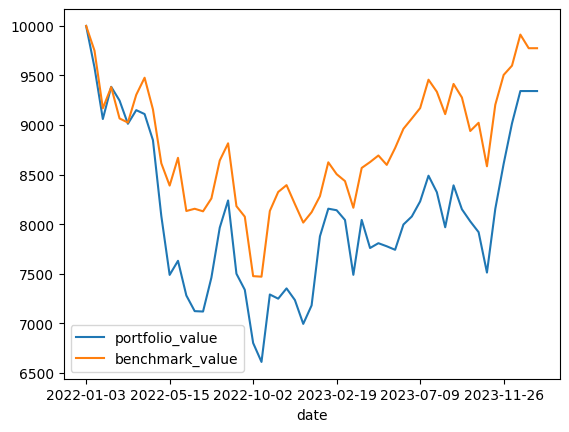

In [38]:
if headers is None:
  print('Header not set, the following queries will not work! Please login before')

model_data = dict(security_by_time=df_test['security_by_time'].to_list(), target=TARGET, values=df_test['predicted_value'].to_list())
r = requests.post('https://api.mlalpha.com/v0.1/mlds/benchmark_test_ds', json=model_data, headers=headers)

if r.status_code == 200:
  data = r.json()
  print(f'performce metrics: mse={data["mse"]}, rmse={data["rmse"]}, corr={data["corr"]}, mae={data["mae"]}, r2={data["r2"]}')

  print('')
  print(f'The portfolio based on the output of the machine learning algorithm has made the following performance')
  print(f"Portfolio: CARG: {data['periodCAGR']}%, total return: {data['periodCumulativeReturn']}%, sharpe ratio: {data['periodSharpe']}, max drawdown: {data['periodMaxDrawdown']}%")
  print(f"S&P500: CARG: {data['periodCAGRBench']}%, total return: {data['periodCumulativeReturnBench']}%, sharpe ratio: {data['periodSharpeBench']}, max drawdown: {data['periodMaxDrawdownBench']}%")


  df_perf = pd.DataFrame({'date': data['periodPortfolioValuePlot']['dates'], 'portfolio_value': data['periodPortfolioValuePlot']['prices'], 'benchmark_value': data['periodPortfolioValuePlot']['benchmarkPrices']})
  df_perf.set_index('date').plot()
else:
  print(f'ERROR when calling the MLALPHA API (error code: {r.status_code}) if 401 is the error code, make sure you are logged-in correctly and the token is passed in the headers, if 500 please contact us and tell us the time of the error ({datetime.now()})')

Hum! not so great as we can see the corr is only 0.035 which is quite low, but I am sure you can make it better!

Enjoy!

## Submit the biweekly predictions

We generate every 2 weeks new data, you can get notified via email or via a notification in the [ML Alpha web portal](https://app.mlalpha.com).

When you are satified with your model you can upload predictions to your Data Sience Porfolilio depending on your target:
- `target_2W`: Biweekly predictions
- `target_1M`: Monthly perdictions
- `target_1Q`: Quarterly predictions

Once you submited your predictions, you need to wait the next period to be able to submit new ones.

[Make sure to checkout our article on how to create a datascience portfolio](https://mlalpha.com/2024/01/16/how-to-upload-predictions-to-ml-alpha/?swcfpc=1)


### Generate predictions for the current data

In [39]:
print('Predict on current')
y_pred_current = model.predict(df_to_predict[FEATURES].values)
df_to_predict['predicted_value'] = y_pred_current

Predict on current


**Get this information from [ML Alpha Porfolios](https://app.mlalpha.com/my-portfolios) By selecting your datasicene portfolio**

In [40]:
PORTFOLIO_ID=67

In [46]:
if headers is None:
  print('Header not set, the following queries will not work! Please login before')
else:
  model_data = dict(portfolio_id=PORTFOLIO_ID, security_by_time=df_to_predict['security_by_time'].to_list(), target=TARGET, values=df_to_predict['predicted_value'].to_list())
  r = requests.post('https://api.mlalpha.com/v0.1/mlds/submit_predictions', json=model_data, headers=headers)
  data = r.json()

  if r.status_code == 200:
    print('Predictions have been submitted! Good Luck!')
    print(f'stocks predicted: {data["predicted_symbols"]}')
  else:
    print(f'It looks like there is an error {r.status_code}: {data["msg"]}')

Predictions have been submitted! Good Luck!
stocks predicted: ['TY', 'TCN', 'FICO', 'NGL', 'QLYS', 'MCO', 'MAS', 'HLNE', 'SBAC', 'NFJ', 'COOP', 'KRC', 'MYO', 'GRND', 'INTU']
